# Matrix Decomposition of User-Ratings

1. Find optimal number of principal components to explain 85% of all variance 
2. Look at the first 2 principal components and see what they are trying to explain
3. Cluster user-ratings matrix as an attempt to uncover user behavior.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import csv

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans


%matplotlib inline

In [2]:
input_path = '../joke_recommender/data/'
df = pd.read_csv(input_path + 'joke_dataframe.csv')
df = df.drop(['Unnamed: 0', 'JokeId'], axis = 1)

## Matrix Decomposition Using sklearn TruncatedSVD
We scale our values between 1 and 2 and set NaN to zero to get rid of NaN values. We then preform tSVD on the resulting scaled matrix. We do not need to normalize because all features are on the same scale.

In [3]:
X = np.array(df)
scaler = MinMaxScaler(feature_range=(1,2))
scaler.fit(X)
X_transform = scaler.transform(X)
X = np.nan_to_num(X_transform)

### How much variance in the original user-ratings matrix is explained by each principal component (PC)

[Text(0, 0.5, 'Variance Explained'), Text(0.5, 0, 'Number of Components')]

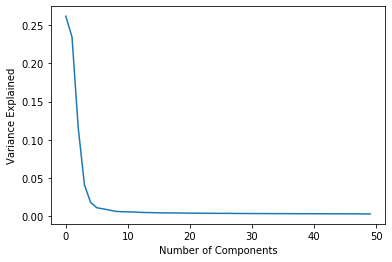

In [4]:
svd = TruncatedSVD(n_components=50)
svd.fit(X)
evr = svd.explained_variance_ratio_
ax = sns.lineplot(x = range(0,50), y = evr)
ax.set(xlabel = 'Number of Components', ylabel = 'Variance Explained')

### Cumulative variance in the original user-ratings matrix explained by each principal component (PC)

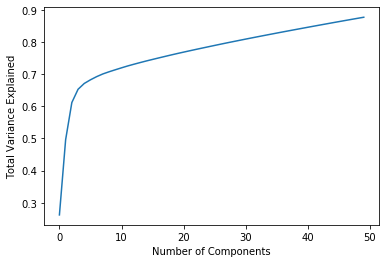

In [5]:
evr_sum = np.cumsum(evr)
ax = sns.lineplot(x = range(0,50), y = evr_sum)
ax.set(xlabel = 'Number of Components', ylabel = 'Total Variance Explained')
plt.savefig('./images/PCA_users.png', dpi = 300)

We arbitrarily choose 85% as 'good enough' variance explained, and try to choose the number of principal components that will cumulatively explain 85% of the variance.

In [6]:
#We chose a evr_sum of 0.8
np.where(np.logical_and (evr_sum > 0.79, evr_sum < 0.81))

(array([25, 26, 27, 28, 29, 30]),)

## Loadings of the first two principal components
We fit the SVD with the optimal number of principal components and explore the first two components

In [7]:
opt_svd = TruncatedSVD(n_components=28)
svd_X = opt_svd.fit_transform(X)

#### First Component
Top five loadings

In [8]:
joke_frame = pd.read_csv(input_path + 'JokeText.csv')
jokes = joke_frame.JokeText
for i in range(1,6):
    print(jokes[np.argsort(svd_X[:,0])[-i]])
    print('------------------------------------------------------')

A guy goes into confession and says to the priest, "Father, I'm 80 years
old, widower, with 11 grandchildren. Last night I met two beautiful flight
attendants. They took me home and I made love to both of them. Twice."

The priest said: "Well, my son, when was the last time you were in
confession?"
 "Never Father, I'm Jewish."
 "So then, why are you telling me?"
 "I'm telling everybody."

------------------------------------------------------
A guy walks into a bar, orders a beer and says to the bartender,
"Hey, I got this great Polish Joke..." 

The barkeep glares at him and says in a warning tone of voice:
"Before you go telling that joke you better know that I'm Polish, both
bouncers are Polish and so are most of my customers"

"Okay" says the customer,"I'll tell it very slowly." 

------------------------------------------------------
Clinton returns from a vacation in Arkansas and walks down  the
steps of Air Force One with two pigs under his arms.  At the bottom
of the steps, he 

Bottom five loadings

In [9]:
for i in range(1,6):
    print(jokes[np.argsort(svd_X[:,0])[i]])
    print('------------------------------------------------------')

Q: How many stalkers does it take to change a light bulb?

A: Two. One to replace the bulb, and the other to watch it day and night.

------------------------------------------------------
Q: Do you know the difference between an intelligent male and the
Sasquatch?

A: There have been actual reported sightings of the Sasquatch.

------------------------------------------------------
Q: What is the difference between George  Washington, Richard Nixon,
and Bill Clinton?

A: Washington couldn't tell a lie, Nixon couldn't   tell the truth, and
Clinton doesn't know the difference.

------------------------------------------------------
Q: Ever wonder why the IRS calls it Form 1040?

A: Because for every $50 that you earn, you get 10 and they get 40.

------------------------------------------------------
If pro- is the opposite of con- then congress must be the opposite
of progress.

------------------------------------------------------


**Interesting! it seems as though in the first principal component, the highest 5 scores relate to long jokes, and the lowest 5 loadings correspond to really short one-liner jokes!**

The first principal component seems to represent the users who prefer a certian length of the joke itself.

In [10]:
print('This explains over {0}% of all variance in the user-ratings matrix!'.format(round(evr[0]*100,2)))

This explains over 26.15% of all variance in the user-ratings matrix!


## Plotting PC1 on PC2
We can see 3-4 small groups of users forming here. 

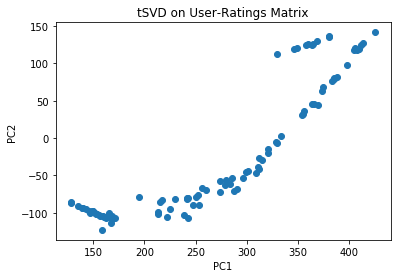

In [11]:
plt.scatter(svd_X[:,0],svd_X[:,1])
plt.title('tSVD on User-Ratings Matrix')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('./images/tSVD_on_User_rat_mat.png', dpi = 300)

## K-Means Clustering
We're going to use the elbow method to determine the best cluster number to use

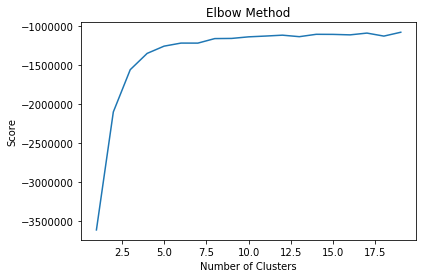

In [12]:
# TESTING FOR THE OPTIMAL NUMBER OF K CLUSTERS FOR THE KMEANS MODEL
number_clusters = range(1, 20)

kmeans = [MiniBatchKMeans(n_clusters=i, batch_size = 50, init= 'k-means++', max_iter = 100) for i in number_clusters]
score = [kmeans[i].fit(X.T).score(X.T) for i in tqdm_notebook(range(len(kmeans)))]
# PLOTTING ELBOW PLOT
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.savefig('./images/elbow_method_kmeans_users.png', dpi = 300)
plt.show()

## Fitting and Visualizing the K-Means Clusters

In [13]:
k_value = 6
kmeans = MiniBatchKMeans(n_clusters=k_value, batch_size = 100, init= 'k-means++', max_iter = 100)
fitted_values= kmeans.fit(X.T)
predicted_values = kmeans.predict(X.T)

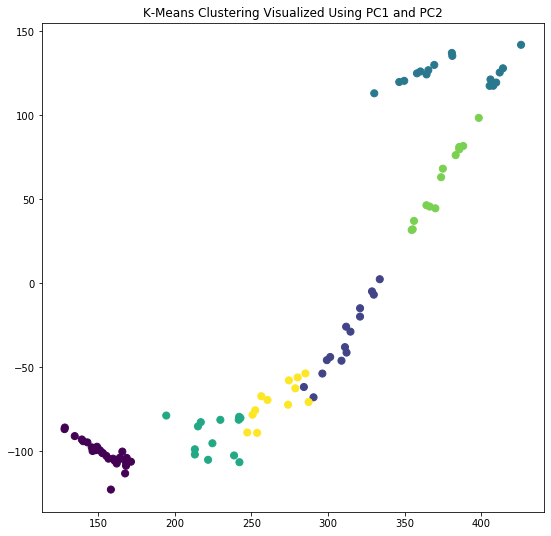

In [14]:
k_value = 6
kmeans_svd = MiniBatchKMeans(n_clusters=k_value, batch_size = 100, init= 'k-means++', max_iter = 100)
fitted_values_svd= kmeans_svd.fit(svd_X)
predicted_values_svd = kmeans_svd.predict(svd_X)
centers = kmeans_svd.cluster_centers_
plt.figure(figsize = (9,9))
plt.scatter(svd_X[:,0], svd_X[:,1], c=predicted_values_svd, s=50, cmap='viridis')
plt.title('K-Means Clustering Visualized Using PC1 and PC2')
plt.savefig('./images/Kmeans_Clustering_on_User_Data.png', dpi = 300)

## We can now see which users belong in which clusters!
Here we extract the users and the clusters they belong to into a dataframe.

In [15]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df.columns.values
cluster_map['cluster'] = kmeans.labels_

## What are the highest rated jokes from cluster 0?

In [16]:
for i in range(1,6):
    print(jokes[np.argsort(np.mean(df.iloc[:,cluster_map.index[cluster_map.cluster == 0].values], axis = 1).values)[-i]])

Q. What's the difference between a man and a toilet? 

A. A toilet doesn't follow you around after you use it.

A country guy goes into a city bar that has a dress code, and the maitre
d' 
demands he wear a tie. Discouraged, the guy goes to his car to sulk when 
inspiration strikes: He's got jumper cables in the trunk! So he wraps
them around his neck, sort of like a string tie (a bulky string tie to be
sure) and returns to the bar. The maitre d' is reluctant, but says to the
guy, "Okay, you're a pretty resourceful fellow, you can come in... but
just don't start anything"!  

Q. What do a hurricane, a tornado, and a redneck
divorce all have in common? 
A. Someone's going to lose their trailer...

Two kindergarten girls were talking outside: one said, "You
won't believe what I saw on the patio yesterday--a condom!"

The second girl asked, "What's a patio?"

A guy goes into confession and says to the priest, "Father, I'm 80 years
old, widower, with 11 grandchildren. Last night I met two 

## What are the lowest rated jokes from cluster 0?

In [17]:
for i in range(5):
    print(jokes[np.argsort(np.mean(df.iloc[:,cluster_map.index[cluster_map.cluster == 0].values], axis = 1).values)[i]])

Bill & Hillary are on a trip back to Arkansas. They're almost out of gas, so Bill pulls into a service station on the outskirts of
town. The attendant runs out of the station to serve them when Hillary realizes it's an old boyfriend from high school. She and
the attendant chat as he gases up their car and cleans the windows. Then they all say good-bye. 

As Bill pulls the car onto the road, he turns to Hillary and says, 'Now aren't you glad you married me and not him ? You could've
been the wife of a grease monkey !' 

To which Hillary replied, 'No, Bill. If I would have married him, you'd be pumping gas and he would be the President !' 

How many teddybears does it take to change a lightbulb?

It takes only one teddybear, but it takes a whole lot of lightbulbs.

What do you get when you run over a parakeet with a lawnmower? 
Shredded tweet.

Q: What is the Australian word for a boomerang that won't
   come back? 

A: A stick

Q. What is orange and sounds like a parrot?  

A. A carrot.